In [99]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [100]:
# Load the dataset
rawdata = pd.read_csv(r'E:\Users\Documents\College\Engineering\S.Y. Eng\Machine Learning\sms_data.csv')

In [101]:
data = rawdata.dropna()

In [102]:
# Step 1: Inspect the dataset
print("Dataset Overview:")
print(data.info())
print("\nSample Messages:")
print(data['body'].head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 5052 entries, 0 to 5055
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sms_data_id  5052 non-null   object 
 1   user_id      5052 non-null   int64  
 2   sms_id       5052 non-null   float64
 3   body         5052 non-null   object 
 4   creator      5052 non-null   object 
 5   date         5052 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 276.3+ KB
None

Sample Messages:
0    INR 6 debited from your YES BANK prepaid card ...
1    आपके Jio नंबर 9653181533  के प्लान की वैधता जल...
2    Hey, Save Rs.100 extra on groceries & more wit...
3    INR 6 debited from your YES BANK prepaid card ...
4    INR 6 debited from your YES BANK prepaid card ...
Name: body, dtype: object


In [103]:
# Step 2: Preprocess the text
def preprocess_text(text):
    # Remove URLs, special characters, and numbers
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower()

In [104]:
# Apply preprocessing
data['cleaned_body'] = data['body'].apply(preprocess_text)

C:\Users\Shubham\AppData\Local\Temp\ipykernel_17328\47302210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_body'] = data['body'].apply(preprocess_text)


In [105]:
# Step 3: Visualize word frequencies
vectorizer = CountVectorizer(stop_words='english', max_features=50)
X = vectorizer.fit_transform(data['cleaned_body'])

In [106]:
# Create a DataFrame for visualization
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': X.toarray().sum(axis=0)
})

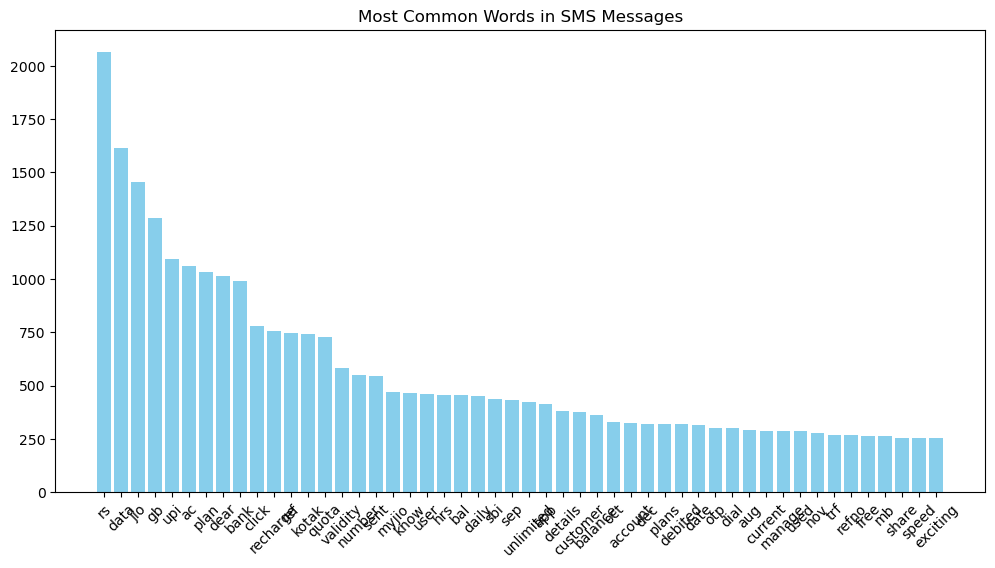

In [107]:
# Plot the most common words
word_freq = word_freq.sort_values(by='frequency', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(word_freq['word'], word_freq['frequency'], color='skyblue')
plt.title('Most Common Words in SMS Messages')
plt.xticks(rotation=45)
plt.show()

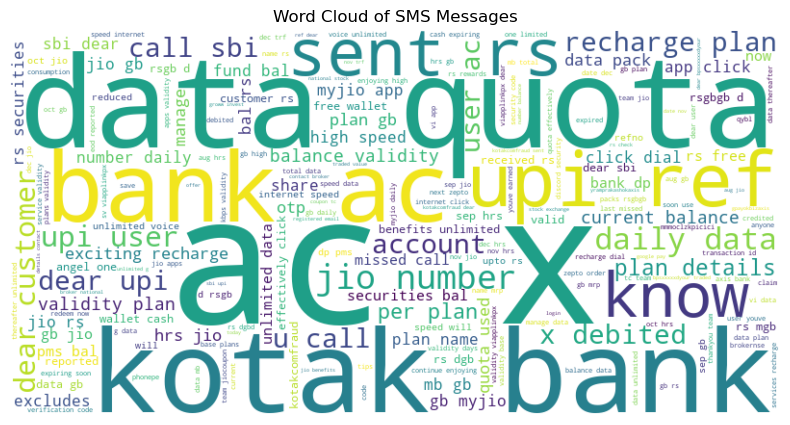

In [108]:
# Step 4: Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['cleaned_body']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of SMS Messages')
plt.show()

In [109]:
# Step 5: Add Labels (improved labeling logic)
def label_message(text):
    spam_keywords = ["win", "offer", "free", "congratulations", "urgent", "lottery", "claim", "prize"]
    for word in spam_keywords:
        if word in text.lower():
            return 'spam'
    return 'not spam'

data['label'] = data['body'].apply(label_message)

C:\Users\Shubham\AppData\Local\Temp\ipykernel_17328\3513248382.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['body'].apply(label_message)


In [110]:
# Step 6: Train-Test Split
X = data['cleaned_body']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
# Step 7: Text Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [112]:
# Step 8: Train a Naive Bayes Classifier
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [113]:
# Step 9: Evaluate the Model
y_pred = model.predict(X_test_tfidf)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    not spam       0.97      1.00      0.98       918
        spam       0.96      0.72      0.82        93

    accuracy                           0.97      1011
   macro avg       0.96      0.86      0.90      1011
weighted avg       0.97      0.97      0.97      1011


Confusion Matrix:
[[915   3]
 [ 26  67]]


In [114]:
y_pred

array(['not spam', 'not spam', 'not spam', ..., 'not spam', 'not spam',
       'not spam'], dtype='<U8')

In [115]:
# Step 10: Predict on New Messages
def categorize_message(message):
    processed_message = preprocess_text(message)
    vectorized_message = tfidf_vectorizer.transform([processed_message])
    return model.predict(vectorized_message)[0]

In [116]:
# Example Usage
new_message = "Congratulations! You've won a free trip to Bahamas. Reply to claim your prize."
print(f"Message: '{new_message}'\nCategory: {categorize_message(new_message)}")

Message: 'Congratulations! You've won a free trip to Bahamas. Reply to claim your prize.'
Category: spam


In [117]:
messages = [
    "Congratulations! You've won a free trip to Bahamas. Reply to claim your prize.",
    "URGENT: You are selected for a cash reward! Call now to claim.",
    "Get your exclusive discount offer. Limited time only!",
    "Hey, can we meet tomorrow for coffee? Let me know your schedule.",
    "Reminder: Your doctor’s appointment is scheduled for 10:00 AM on Monday.",
    "Happy Birthday! Hope you have an amazing day.",
    "click the link to get 100 rupees"
]

for msg in messages:
    print(f"Message: '{msg}'\nCategory: {categorize_message(msg)}\n")


Message: 'Congratulations! You've won a free trip to Bahamas. Reply to claim your prize.'
Category: spam

Message: 'URGENT: You are selected for a cash reward! Call now to claim.'
Category: spam

Message: 'Get your exclusive discount offer. Limited time only!'
Category: not spam

Message: 'Hey, can we meet tomorrow for coffee? Let me know your schedule.'
Category: not spam

Message: 'Reminder: Your doctor’s appointment is scheduled for 10:00 AM on Monday.'
Category: not spam

Message: 'Happy Birthday! Hope you have an amazing day.'
Category: not spam

Message: 'click the link to get 100 rupees'
Category: not spam

